<a href="https://colab.research.google.com/github/christophergaughan/medical-imaging-pytorch/blob/main/08_3D_Liver_Tumor_Segmentation_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Liver and Tumor Segmentation from CT

## The Capstone Project

This notebook represents the culmination of our medical imaging journey. We'll tackle **true 3D segmentation** — processing entire volumetric CT scans with 3D convolutions, not slice-by-slice approximations.

**What makes this different:**

| Previous Notebooks | This Notebook |
|-------------------|---------------|
| 2D convolutions on slices | 3D convolutions on volumes |
| Binary segmentation (0/1) | Multi-class (background/liver/tumor) |
| Standard augmentation | TorchIO for 3D transforms |
| Full images | Patch-based training (memory) |
| ~7M parameters | Memory-optimized architecture |

**Clinical Context:**

Liver cancer is the 6th most common cancer and 4th leading cause of cancer death worldwide. Accurate segmentation enables:
- Surgical planning (tumor resection margins)
- Radiation therapy targeting
- Treatment response monitoring
- Liver volumetry for transplant assessment

**Dataset:** [Medical Segmentation Decathlon - Task03_Liver](http://medicaldecathlon.com/) (resampled to 256×256×Z)

---

## Table of Contents

1. [Mathematical Foundations](#math) — 3D convolutions, multi-class losses
2. [Data Exploration](#data) — Understanding the volumetric data
3. [The 3D U-Net Architecture](#model) — From 2D to 3D
4. [Training Pipeline](#training) — TorchIO, patch-based training
5. [Evaluation & Visualization](#eval) — 3D Dice, volume rendering
6. [Lessons Learned](#lessons) — Reflections on the course

---

<a id='math'></a>
# Part 1: Mathematical Foundations

## 3D Convolutions

In 2D convolutions, we slide a kernel across height and width:

$$\text{2D: } (C_{out}, C_{in}, k_H, k_W) \circledast (B, C_{in}, H, W) \rightarrow (B, C_{out}, H', W')$$

In 3D, we add depth:

$$\text{3D: } (C_{out}, C_{in}, k_D, k_H, k_W) \circledast (B, C_{in}, D, H, W) \rightarrow (B, C_{out}, D', H', W')$$

**Why 3D matters:**

Medical structures are inherently 3D. A tumor that appears as two separate regions in 2D slices might be a single connected mass in 3D. By using 3D convolutions, we capture:
- **Spatial continuity** across slices
- **Volumetric context** for each voxel
- **3D shape priors** (tumors are roughly spherical, not flat)

**Memory cost:**

A 3×3 2D kernel has 9 parameters. A 3×3×3 3D kernel has 27 parameters — 3× more. Combined with the additional dimension in feature maps, memory grows cubically. This is why we use smaller filter counts (32→64→128→256 vs 64→128→256→512).

---

## Multi-Class Segmentation

### From Binary to Multi-Class

Previously, we had two classes (background/foreground) and used:
- **Sigmoid** activation: $\sigma(x) = \frac{1}{1 + e^{-x}}$
- **BCE Loss**: $-[y \log(\hat{y}) + (1-y)\log(1-\hat{y})]$

Now we have three classes (background/liver/tumor). We use:
- **Softmax** activation: $\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$
- **Cross-Entropy Loss**: $-\sum_c y_c \log(\hat{y}_c)$

### The Softmax Function

Softmax converts raw logits into a probability distribution:

$$P(\text{class} = c | x) = \frac{e^{z_c}}{\sum_{k=1}^{K} e^{z_k}}$$

Properties:
- All outputs sum to 1
- Each output ∈ (0, 1)
- Mutually exclusive classes (each voxel is exactly one class)

### Multi-Class Dice Loss

The Dice coefficient generalizes to multiple classes:

$$\text{Dice}_c = \frac{2 |P_c \cap G_c|}{|P_c| + |G_c|} = \frac{2 \sum_i p_{ic} g_{ic}}{\sum_i p_{ic} + \sum_i g_{ic}}$$

Where $p_{ic}$ is the predicted probability for class $c$ at voxel $i$, and $g_{ic}$ is the ground truth (one-hot encoded).

**Multi-class Dice Loss:**

$$\mathcal{L}_{Dice} = 1 - \frac{1}{C} \sum_{c=1}^{C} \text{Dice}_c$$

We can also weight classes differently to handle imbalance:

$$\mathcal{L}_{Dice}^{weighted} = 1 - \sum_{c=1}^{C} w_c \cdot \text{Dice}_c$$

---

## Setup

In [1]:
# Install dependencies
!pip install nibabel torchio pytorch-lightning celluloid --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 66.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Core imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Medical imaging
import nibabel as nib
import torchio as tio

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

print(f"PyTorch: {torch.__version__}")
print(f"TorchIO: {tio.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.9.0+cu126
TorchIO: 0.21.0
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.2 GB


In [5]:
# Set paths
DATA_ROOT = Path("/content/drive/MyDrive/AI_Medical_Images/08-3d-Liver-Tumor-Segmentation/Task03_Liver_rs")
IMAGES_DIR = DATA_ROOT / "imagesTR"  # Capital R!
LABELS_DIR = DATA_ROOT / "labelsTr"

# Filter out macOS resource forks
image_files = sorted([f for f in IMAGES_DIR.glob("*.nii.gz") if not f.name.startswith("._")])
label_files = sorted([f for f in LABELS_DIR.glob("*.nii.gz") if not f.name.startswith("._")])

print(f"Found {len(image_files)} CT volumes")
print(f"Found {len(label_files)} label masks")

Found 123 CT volumes
Found 123 label masks


---
<a id='data'></a>
# Part 2: Data Exploration

## Understanding the Data

**Label encoding:**
- 0 = Background
- 1 = Liver
- 2 = Tumor

This is a **hierarchical segmentation** problem: tumors are always inside the liver. The model must learn:
1. Where is the liver? (large organ, consistent location)
2. Within the liver, where are tumors? (small, variable)

In [6]:
def change_img_to_label_path(path: Path) -> Path:
    """Convert image path to corresponding label path."""
    parts = list(path.parts)
    parts[parts.index("imagesTR")] = "labelsTr"  # Capital R → lowercase r
    return Path(*parts)

In [7]:
# Load a sample volume
sample_path = image_files[0]
sample_label_path = change_img_to_label_path(sample_path)

print(f"CT: {sample_path.name}")
print(f"Mask: {sample_label_path.name}")

ct_nii = nib.load(sample_path)
mask_nii = nib.load(sample_label_path)

ct = ct_nii.get_fdata()
mask = mask_nii.get_fdata().astype(np.int32)

print(f"\nCT shape: {ct.shape}")
print(f"CT range: [{ct.min():.0f}, {ct.max():.0f}] HU")
print(f"Voxel spacing: {ct_nii.header.get_zooms()}")
print(f"Orientation: {nib.aff2axcodes(ct_nii.affine)}")

# Class distribution
unique, counts = np.unique(mask, return_counts=True)
total = counts.sum()
print(f"\nClass distribution:")
class_names = ['Background', 'Liver', 'Tumor']
for val, count in zip(unique, counts):
    print(f"  {class_names[int(val)]}: {count:,} voxels ({100*count/total:.2f}%)")

CT: liver_0.nii.gz
Mask: liver_0.nii.gz

CT shape: (180, 180, 125)
CT range: [-1024, 1343] HU
Voxel spacing: (np.float32(2.0), np.float32(2.0), np.float32(3.0))
Orientation: ('R', 'A', 'S')

Class distribution:
  Background: 3,936,285 voxels (97.19%)
  Liver: 113,169 voxels (2.79%)
  Tumor: 546 voxels (0.01%)


### Visualize the Volume

Note the class imbalance: background >> liver >> tumor. This motivates our loss function choices.

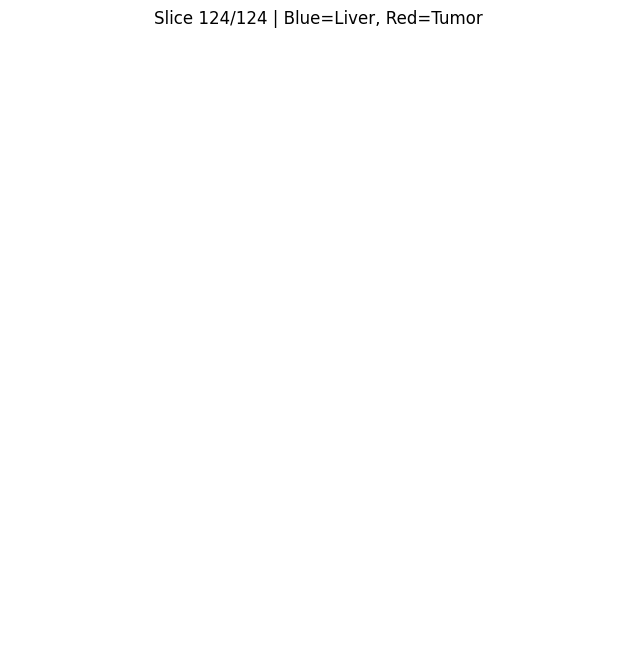

In [8]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
camera = Camera(fig)

# Custom colormap for multi-class
# 0 = transparent, 1 = blue (liver), 2 = red (tumor)
for i in range(0, ct.shape[2], 2):  # Skip every 2nd slice
    plt.imshow(ct[:, :, i], cmap="bone", vmin=-200, vmax=300)

    # Overlay liver in blue
    liver_mask = np.ma.masked_where(mask[:, :, i] != 1, mask[:, :, i])
    plt.imshow(liver_mask, alpha=0.3, cmap='Blues', vmin=0, vmax=2)

    # Overlay tumor in red
    tumor_mask = np.ma.masked_where(mask[:, :, i] != 2, mask[:, :, i])
    plt.imshow(tumor_mask, alpha=0.7, cmap='Reds', vmin=0, vmax=2)

    plt.title(f"Slice {i}/{ct.shape[2]-1} | Blue=Liver, Red=Tumor")
    plt.axis('off')
    camera.snap()

animation = camera.animate(interval=100)
HTML(animation.to_html5_video())

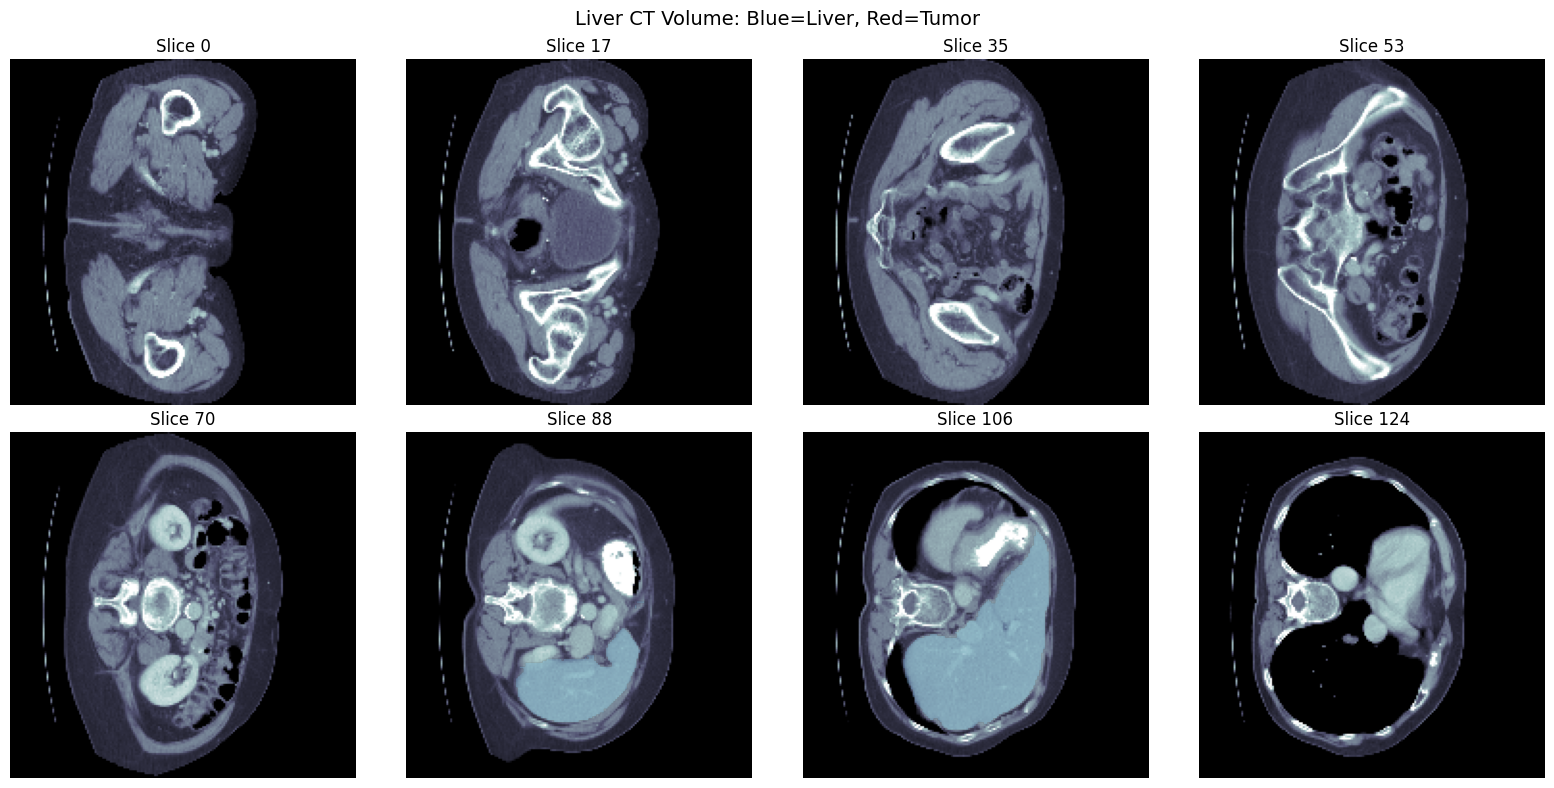

In [9]:
# Static figure for GitHub (animation doesn't render)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

slice_indices = np.linspace(0, ct.shape[2]-1, 8).astype(int)

for idx, ax in enumerate(axes.flat):
    i = slice_indices[idx]
    ax.imshow(ct[:, :, i], cmap='bone', vmin=-200, vmax=300)

    # Overlay liver in blue
    liver_mask = np.ma.masked_where(mask[:, :, i] != 1, mask[:, :, i])
    ax.imshow(liver_mask, alpha=0.3, cmap='Blues', vmin=0, vmax=2)

    # Overlay tumor in red
    tumor_mask = np.ma.masked_where(mask[:, :, i] != 2, mask[:, :, i])
    ax.imshow(tumor_mask, alpha=0.7, cmap='Reds', vmin=0, vmax=2)

    ax.set_title(f'Slice {i}')
    ax.axis('off')

plt.suptitle('Liver CT Volume: Blue=Liver, Red=Tumor', fontsize=14)
plt.tight_layout()
plt.show()

---

## Train/Validation Split

### Why Split Matters

**The goal:** Estimate how well our model will perform on *unseen* data.

**The trap:** If we evaluate on training data, we measure *memorization*, not *generalization*.

**Our approach:**

| Set | Purpose | Size | Usage |
|-----|---------|------|-------|
| **Train** | Learn parameters | ~80% | Gradient updates |
| **Validation** | Tune hyperparameters | ~20% | Early stopping, model selection |
| **Test** | Final evaluation | Held out | Report final metrics |

**Important:** Validation set must be *representative* of the test distribution. In medical imaging, this means:
- Different patients (no data leakage from same patient in train/val)
- Similar disease distribution
- Similar acquisition protocols

For this dataset with ~130 subjects, we'll use ~105 for training and ~26 for validation.

In [10]:
# Train/val split
n_subjects = len(image_files)
n_train = int(0.8 * n_subjects)
n_val = n_subjects - n_train

print(f"Total subjects: {n_subjects}")
print(f"Training: {n_train} ({100*n_train/n_subjects:.0f}%)")
print(f"Validation: {n_val} ({100*n_val/n_subjects:.0f}%)")

train_images = image_files[:n_train]
val_images = image_files[n_train:]

Total subjects: 123
Training: 98 (80%)
Validation: 25 (20%)


---

## TorchIO: 3D Medical Image Handling

TorchIO is purpose-built for 3D medical imaging. It handles:

1. **Loading** — NIfTI, DICOM, etc.
2. **Preprocessing** — Resampling, normalization, cropping
3. **Augmentation** — 3D transforms (rotation, elastic, etc.)
4. **Patch-based training** — Extract random patches from large volumes

### Why Patches?

A 256×256×256 volume with 32 filters:
- Feature map size: 256³ × 32 × 4 bytes = **2 GB** per layer!

Solution: Train on smaller patches (e.g., 128×128×128), then inference on full volume.

### TorchIO Subject

A `Subject` bundles the CT and mask together, ensuring they're always transformed identically.

In [11]:
def create_subject(image_path: Path) -> tio.Subject:
    """Create a TorchIO Subject from image and label paths."""
    label_path = change_img_to_label_path(image_path)

    return tio.Subject(
        ct=tio.ScalarImage(image_path),
        mask=tio.LabelMap(label_path)
    )

In [12]:
# Create subjects
train_subjects = [create_subject(p) for p in tqdm(train_images, desc="Loading train")]
val_subjects = [create_subject(p) for p in tqdm(val_images, desc="Loading val")]

print(f"\nTrain subjects: {len(train_subjects)}")
print(f"Val subjects: {len(val_subjects)}")

Loading train:   0%|          | 0/98 [00:00<?, ?it/s]

Loading val:   0%|          | 0/25 [00:00<?, ?it/s]


Train subjects: 98
Val subjects: 25


### Preprocessing Pipeline

For CT:
1. **Clip** intensities to relevant range (liver window)
2. **Normalize** to zero mean, unit variance
3. **Resample** to isotropic voxels (optional)

For training, we also add augmentation:
- Random affine (rotation, scaling)
- Random elastic deformation
- Random flip

In [13]:
# Preprocessing (applied to all data)
preprocess = tio.Compose([
    tio.Clamp(out_min=-200, out_max=300),  # Liver CT window
    tio.ZNormalization(),  # Zero mean, unit variance
])

# Augmentation (training only)
augment = tio.Compose([
    tio.RandomAffine(
        scales=(0.9, 1.1),
        degrees=15,
        p=0.5
    ),
    tio.RandomFlip(axes=(0, 1, 2), p=0.5),
    tio.RandomNoise(std=0.1, p=0.25),
])

# Combined transforms
train_transform = tio.Compose([preprocess, augment])
val_transform = preprocess  # No augmentation for validation!

In [14]:
# Create datasets
train_dataset = tio.SubjectsDataset(train_subjects, transform=train_transform)
val_dataset = tio.SubjectsDataset(val_subjects, transform=val_transform)

print(f"Train dataset: {len(train_dataset)} subjects")
print(f"Val dataset: {len(val_dataset)} subjects")

Train dataset: 98 subjects
Val dataset: 25 subjects


### Patch-Based Sampling

For training, we extract random patches. TorchIO's `Queue` system:
1. Loads subjects into memory
2. Extracts patches on-the-fly
3. Balances patches to include foreground (liver/tumor)

**Label sampler:** Ensures we sample patches that contain liver/tumor, not just background.

In [15]:
# # Patch configuration
# PATCH_SIZE = (128, 128, 128)  # 3D patch size
# PATCHES_PER_VOLUME = 8  # Patches extracted per subject
# QUEUE_LENGTH = 200  # Patches in queue
# BATCH_SIZE = 2  # Limited by GPU memory

# # Sampler that prefers patches with labels
# sampler = tio.data.LabelSampler(
#     patch_size=PATCH_SIZE,
#     label_name='mask',
#     label_probabilities={0: 0.1, 1: 0.5, 2: 0.4}  # Prefer liver and tumor
# )

# # Training queue
# train_queue = tio.Queue(
#     train_dataset,
#     max_length=QUEUE_LENGTH,
#     samples_per_volume=PATCHES_PER_VOLUME,
#     sampler=sampler,
#     num_workers=2
# )

# # DataLoader from queue
# train_loader = torch.utils.data.DataLoader(
#     train_queue,
#     batch_size=BATCH_SIZE,
#     num_workers=0  # Queue handles workers
# )

# print(f"Patch size: {PATCH_SIZE}")
# print(f"Batch size: {BATCH_SIZE}")
# print(f"Patches per epoch: ~{len(train_dataset) * PATCHES_PER_VOLUME}")

In [16]:
# Simpler approach - bypasses TorchIO Queue API issues
class SimpleLiverDataset(torch.utils.data.Dataset):
    """Simple dataset that loads patches on-the-fly."""

    def __init__(self, subjects, transform, patch_size=(128, 128, 128), patches_per_volume=4):
        self.subjects = subjects
        self.transform = transform
        self.patch_size = patch_size
        self.patches_per_volume = patches_per_volume

        # Add padding to handle border cases
        half_patch = tuple(p // 2 for p in patch_size)
        self.pad = tio.Pad(half_patch)

        self.sampler = tio.data.LabelSampler(patch_size=patch_size, label_name='mask')
        self.uniform_sampler = tio.data.UniformSampler(patch_size=patch_size)  # Fallback

    def __len__(self):
        return len(self.subjects) * self.patches_per_volume

    def __getitem__(self, idx):
        subject_idx = idx // self.patches_per_volume
        subject = self.subjects[subject_idx]

        # Apply transforms then padding
        transformed = self.transform(subject)
        transformed = self.pad(transformed)

        # Try label sampler, fall back to uniform if it fails
        try:
            patches = list(self.sampler(transformed, num_patches=1))
            patch = patches[0]
        except RuntimeError:
            # Fallback to uniform sampling
            patches = list(self.uniform_sampler(transformed, num_patches=1))
            patch = patches[0]

        ct = patch['ct'][tio.DATA]  # (1, D, H, W)
        mask = patch['mask'][tio.DATA]  # (1, D, H, W)

        return ct, mask


# Create datasets
BATCH_SIZE = 4  # Could try 8 if no OOM
train_ds = SimpleLiverDataset(train_subjects, train_transform, patches_per_volume=4)
val_ds = SimpleLiverDataset(val_subjects, val_transform, patches_per_volume=2)

# Create loaders - optimized for A100
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,  # Keeps workers alive between epochs
    prefetch_factor=2  # Preload batches
)

val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

print(f"Train batches per epoch: {len(train_loader)}")
print(f"Val batches per epoch: {len(val_loader)}")

print(f"Train batches per epoch: {len(train_loader)}")
print(f"Val batches per epoch: {len(val_loader)}")

Train batches per epoch: 98
Val batches per epoch: 13
Train batches per epoch: 98
Val batches per epoch: 13


Patch CT shape: (128, 128, 128)
Patch mask shape: (128, 128, 128)


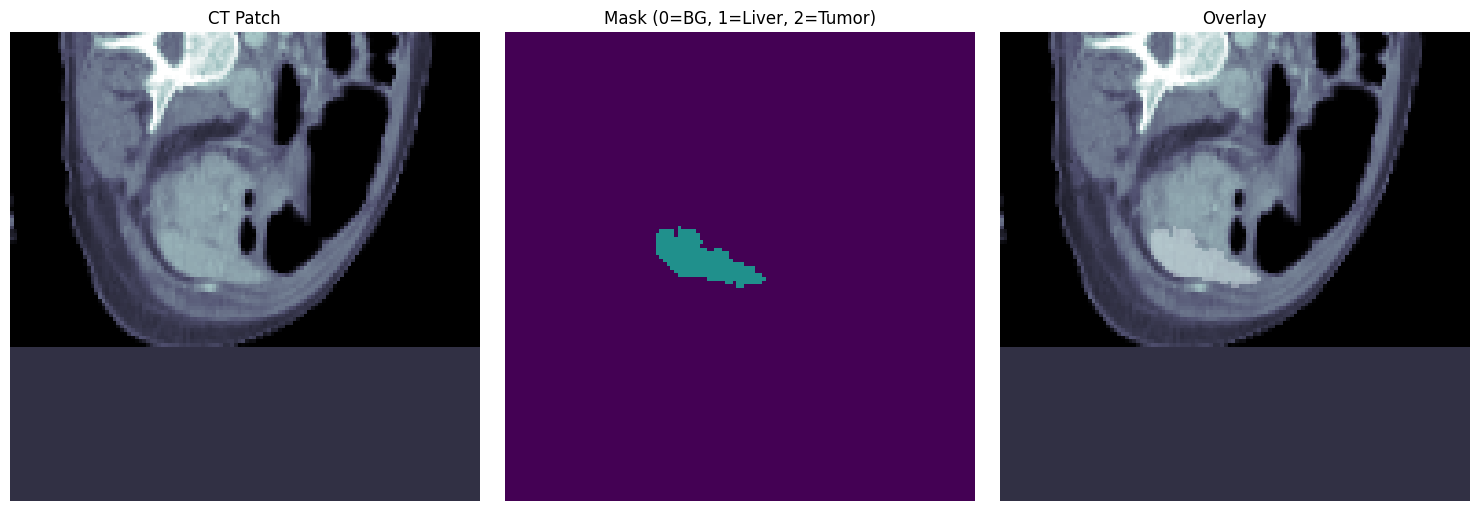

In [17]:
# Visualize a training patch
sample_ct, sample_mask = next(iter(train_loader))
sample_ct_np = sample_ct[0, 0].numpy()  # (D, H, W)
sample_mask_np = sample_mask[0, 0].numpy()

print(f"Patch CT shape: {sample_ct_np.shape}")
print(f"Patch mask shape: {sample_mask_np.shape}")

# Show middle slice
mid = sample_ct_np.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_ct_np[:, :, mid], cmap='bone')
axes[0].set_title('CT Patch')
axes[0].axis('off')

axes[1].imshow(sample_mask_np[:, :, mid], cmap='viridis', vmin=0, vmax=2)
axes[1].set_title('Mask (0=BG, 1=Liver, 2=Tumor)')
axes[1].axis('off')

axes[2].imshow(sample_ct_np[:, :, mid], cmap='bone')
liver = np.ma.masked_where(sample_mask_np[:, :, mid] != 1, sample_mask_np[:, :, mid])
tumor = np.ma.masked_where(sample_mask_np[:, :, mid] != 2, sample_mask_np[:, :, mid])
axes[2].imshow(liver, alpha=0.3, cmap='Blues')
axes[2].imshow(tumor, alpha=0.7, cmap='Reds')
axes[2].set_title('Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [18]:
# # Visualize a training patch
# sample_batch = next(iter(train_loader))
# sample_ct = sample_batch['ct']['data'][0, 0].numpy()  # (D, H, W)
# sample_mask = sample_batch['mask']['data'][0, 0].numpy()

# print(f"Patch CT shape: {sample_ct.shape}")
# print(f"Patch mask shape: {sample_mask.shape}")

# # Show middle slice
# mid = sample_ct.shape[2] // 2

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# axes[0].imshow(sample_ct[:, :, mid], cmap='bone')
# axes[0].set_title('CT Patch')
# axes[0].axis('off')

# axes[1].imshow(sample_mask[:, :, mid], cmap='viridis', vmin=0, vmax=2)
# axes[1].set_title('Mask (0=BG, 1=Liver, 2=Tumor)')
# axes[1].axis('off')

# axes[2].imshow(sample_ct[:, :, mid], cmap='bone')
# liver = np.ma.masked_where(sample_mask[:, :, mid] != 1, sample_mask[:, :, mid])
# tumor = np.ma.masked_where(sample_mask[:, :, mid] != 2, sample_mask[:, :, mid])
# axes[2].imshow(liver, alpha=0.3, cmap='Blues')
# axes[2].imshow(tumor, alpha=0.7, cmap='Reds')
# axes[2].set_title('Overlay')
# axes[2].axis('off')

# plt.tight_layout()
# plt.show()

---
<a id='model'></a>
# Part 3: The 3D U-Net Architecture

## From 2D to 3D

The architecture is conceptually identical to 2D U-Net:
- **Encoder:** Extract features with increasing receptive field
- **Decoder:** Reconstruct spatial resolution
- **Skip connections:** Preserve fine details

Key changes:

| 2D U-Net | 3D U-Net |
|----------|----------|
| `nn.Conv2d` | `nn.Conv3d` |
| `nn.MaxPool2d` | `nn.MaxPool3d` |
| `mode='bilinear'` | `mode='trilinear'` |
| 64→128→256→512 filters | 32→64→128→256 filters (memory!) |
| 1 output channel | 3 output channels (multi-class) |

## Memory Optimization

3D convolutions are memory-hungry. Strategies:
1. **Fewer filters** (32→64→128→256 vs 64→128→256→512)
2. **Smaller patches** (128³ vs full volume)
3. **Mixed precision** (float16 where possible)
4. **Gradient checkpointing** (trade compute for memory)

In [19]:
class DoubleConv3D(nn.Module):
    """
    Double 3D convolution block: (Conv3d → ReLU) × 2

    This is the building block of U-Net. Two convolutions
    allow the network to learn more complex features at each level.
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [20]:
class UNet3D(nn.Module):
    """
    3D U-Net for volumetric segmentation.

    Architecture:
    - Encoder: 4 levels of downsampling
    - Decoder: 4 levels of upsampling
    - Skip connections at each level

    Memory-optimized with reduced filter counts.

    Input: (B, 1, D, H, W) - single channel CT
    Output: (B, 3, D, H, W) - 3 class logits
    """

    def __init__(self, in_channels: int = 1, num_classes: int = 3):
        super().__init__()

        # Encoder (downsampling path)
        # Reduced filter counts for memory efficiency
        self.enc1 = DoubleConv3D(in_channels, 32)
        self.enc2 = DoubleConv3D(32, 64)
        self.enc3 = DoubleConv3D(64, 128)
        self.enc4 = DoubleConv3D(128, 256)  # Bottleneck

        # Decoder (upsampling path)
        self.dec3 = DoubleConv3D(256 + 128, 128)
        self.dec2 = DoubleConv3D(128 + 64, 64)
        self.dec1 = DoubleConv3D(64 + 32, 32)

        # Final 1×1×1 conv for class predictions
        self.final = nn.Conv3d(32, num_classes, kernel_size=1)

        # Pooling
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)                    # (B, 32, D, H, W)
        e2 = self.enc2(self.pool(e1))        # (B, 64, D/2, H/2, W/2)
        e3 = self.enc3(self.pool(e2))        # (B, 128, D/4, H/4, W/4)
        e4 = self.enc4(self.pool(e3))        # (B, 256, D/8, H/8, W/8)

        # Decoder with skip connections
        d3 = F.interpolate(e4, scale_factor=2, mode='trilinear', align_corners=True)
        d3 = torch.cat([d3, e3], dim=1)      # (B, 384, D/4, H/4, W/4)
        d3 = self.dec3(d3)                   # (B, 128, D/4, H/4, W/4)

        d2 = F.interpolate(d3, scale_factor=2, mode='trilinear', align_corners=True)
        d2 = torch.cat([d2, e2], dim=1)      # (B, 192, D/2, H/2, W/2)
        d2 = self.dec2(d2)                   # (B, 64, D/2, H/2, W/2)

        d1 = F.interpolate(d2, scale_factor=2, mode='trilinear', align_corners=True)
        d1 = torch.cat([d1, e1], dim=1)      # (B, 96, D, H, W)
        d1 = self.dec1(d1)                   # (B, 32, D, H, W)

        # Output logits (no softmax - handled by loss)
        return self.final(d1)                # (B, 3, D, H, W)

In [21]:
# Test the model
model = UNet3D()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
test_input = torch.randn(1, 1, 128, 128, 128)
with torch.no_grad():
    test_output = model(test_input)

print(f"\nInput shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
assert test_output.shape == (1, 3, 128, 128, 128), "Output shape mismatch!"

Total parameters: 5,836,099
Trainable parameters: 5,836,099

Input shape: torch.Size([1, 1, 128, 128, 128])
Output shape: torch.Size([1, 3, 128, 128, 128])


---
<a id='training'></a>
# Part 4: Training Pipeline

## Loss Function: Dice + Cross-Entropy

We combine two losses:

1. **Cross-Entropy**: Good gradients, handles multi-class naturally
2. **Dice Loss**: Directly optimizes overlap, handles imbalance


**Combined Loss:** L = L_CE + L_Dice

This combination is standard in medical image segmentation competitions.

In [22]:
class DiceLoss(nn.Module):
    """
    Multi-class Dice Loss.

    Computes Dice for each class and averages.
    """

    def __init__(self, num_classes: int = 3, smooth: float = 1e-5):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Args:
            logits: (B, C, D, H, W) - raw model output
            targets: (B, 1, D, H, W) - integer class labels
        """
        # Softmax to get probabilities
        probs = F.softmax(logits, dim=1)  # (B, C, D, H, W)

        # One-hot encode targets
        targets_onehot = F.one_hot(
            targets.squeeze(1).long(),  # (B, D, H, W)
            num_classes=self.num_classes
        ).permute(0, 4, 1, 2, 3).float()  # (B, C, D, H, W)

        # Compute Dice for each class
        dice_scores = []
        for c in range(self.num_classes):
            pred = probs[:, c].contiguous().view(-1)
            target = targets_onehot[:, c].contiguous().view(-1)

            intersection = (pred * target).sum()
            dice = (2 * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
            dice_scores.append(dice)

        # Average Dice across classes
        mean_dice = torch.stack(dice_scores).mean()

        return 1 - mean_dice  # Dice Loss

In [23]:
class CombinedLoss(nn.Module):
    """
    Combined Cross-Entropy + Dice Loss.

    This is the standard loss for medical image segmentation.
    """

    def __init__(self, num_classes: int = 3, ce_weight: float = 1.0, dice_weight: float = 1.0):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.dice = DiceLoss(num_classes=num_classes)
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # CrossEntropyLoss expects (B, C, ...) and (B, ...) with class indices
        ce_loss = self.ce(logits, targets.squeeze(1).long())
        dice_loss = self.dice(logits, targets)

        return self.ce_weight * ce_loss + self.dice_weight * dice_loss

In [24]:
class LiverSegmentation(pl.LightningModule):
    """
    PyTorch Lightning module for 3D liver and tumor segmentation.
    """

    def __init__(self, learning_rate: float = 1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = UNet3D(in_channels=1, num_classes=3)
        self.loss_fn = CombinedLoss(num_classes=3)
        self.dice_fn = DiceLoss(num_classes=3)
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        ct, mask = batch  # Tuple from SimpleLiverDataset

        logits = self(ct)
        loss = self.loss_fn(logits, mask)

        with torch.no_grad():
            dice_score = 1 - self.dice_fn(logits, mask)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_dice', dice_score, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        ct, mask = batch  # Tuple from SimpleLiverDataset

        logits = self(ct)
        loss = self.loss_fn(logits, mask)
        dice_score = 1 - self.dice_fn(logits, mask)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_dice', dice_score, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

In [25]:
# Fresh model and trainer
model = LiverSegmentation(learning_rate=1e-4)

checkpoint_callback = ModelCheckpoint(
    monitor='val_dice',
    mode='max',
    save_top_k=3,
    filename='liver-{epoch:02d}-{val_dice:.3f}'
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=5,
    precision='16-mixed'
)

# Train!
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that h

┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type         ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ UNet3D       │  5.8 M │ train │     0 │
│ 1 │ loss_fn │ CombinedLoss │      0 │ train │     0 │
│ 2 │ dice_fn │ DiceLoss     │      0 │ train │     0 │
└───┴─────────┴──────────────┴────────┴───────┴───────┘

Trainable params: 5.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.8 M                                                                                                
Total estimated model params size (MB): 23                                                                         
Modules in train mode: 49                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [26]:
# Best checkpoint
print(f"Best model: {checkpoint_callback.best_model_path}")
if checkpoint_callback.best_model_score is not None:
    print(f"Best val dice: {checkpoint_callback.best_model_score:.4f}")

Best model: /content/lightning_logs/version_0/checkpoints/liver-epoch=41-val_dice=0.841.ckpt
Best val dice: 0.8406


---
<a id='eval'></a>
# Part 5: Evaluation & Visualization

## Per-Class Dice Scores

We report Dice separately for each class:
- **Liver Dice**: How well do we segment the liver?
- **Tumor Dice**: How well do we segment tumors within the liver?

Tumor Dice is typically lower because tumors are smaller and more variable.

In [27]:
# Load best model (or use pre-trained weights)
if checkpoint_callback.best_model_path:
    model = LiverSegmentation.load_from_checkpoint(checkpoint_callback.best_model_path)
elif WEIGHTS_DIR.exists():
    weight_files = list(WEIGHTS_DIR.glob("*.ckpt"))
    if weight_files:
        print(f"Loading pre-trained weights: {weight_files[0]}")
        model = LiverSegmentation.load_from_checkpoint(weight_files[0])

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [28]:
def compute_dice_per_class(pred: np.ndarray, target: np.ndarray, num_classes: int = 3) -> dict:
    """
    Compute Dice score for each class.
    """
    dice_scores = {}
    class_names = ['Background', 'Liver', 'Tumor']

    for c in range(num_classes):
        pred_c = (pred == c).astype(float)
        target_c = (target == c).astype(float)

        intersection = (pred_c * target_c).sum()
        dice = (2 * intersection + 1e-5) / (pred_c.sum() + target_c.sum() + 1e-5)

        dice_scores[class_names[c]] = dice

    return dice_scores

In [30]:
# Evaluate on a validation subject
val_subject = val_subjects[0]

# Preprocess
preprocessed = val_transform(val_subject)
ct_data = preprocessed['ct'][tio.DATA]  # Updated API
mask_data = preprocessed['mask'][tio.DATA]

print(f"Volume shape: {ct_data.shape}")

# Pad to dimensions divisible by 8 (for 3 pooling layers)
def pad_to_divisible(tensor, divisor=8):
    """Pad tensor so spatial dims are divisible by divisor."""
    _, d, h, w = tensor.shape
    pad_d = (divisor - d % divisor) % divisor
    pad_h = (divisor - h % divisor) % divisor
    pad_w = (divisor - w % divisor) % divisor
    if pad_d or pad_h or pad_w:
        tensor = F.pad(tensor, (0, pad_w, 0, pad_h, 0, pad_d))
    return tensor, (d, h, w)  # Return original shape for cropping back

ct_padded, orig_shape = pad_to_divisible(ct_data)
ct_volume = ct_padded.unsqueeze(0).to(device)  # (1, 1, D, H, W)

print(f"Padded shape: {ct_volume.shape}")

# Inference
with torch.no_grad():
    logits = model(ct_volume)
    pred_padded = logits.argmax(dim=1).cpu().numpy()[0]

# Crop back to original shape
d, h, w = orig_shape
pred_volume = pred_padded[:d, :h, :w]
mask_volume = mask_data.numpy()[0]

# Compute Dice scores
dice_scores = compute_dice_per_class(pred_volume, mask_volume)

print("\nPer-class Dice Scores:")
for class_name, dice in dice_scores.items():
    print(f"  {class_name}: {dice:.4f}")

Volume shape: torch.Size([1, 244, 244, 162])
Padded shape: torch.Size([1, 1, 248, 248, 168])

Per-class Dice Scores:
  Background: 0.9980
  Liver: 0.9003
  Tumor: 0.0000


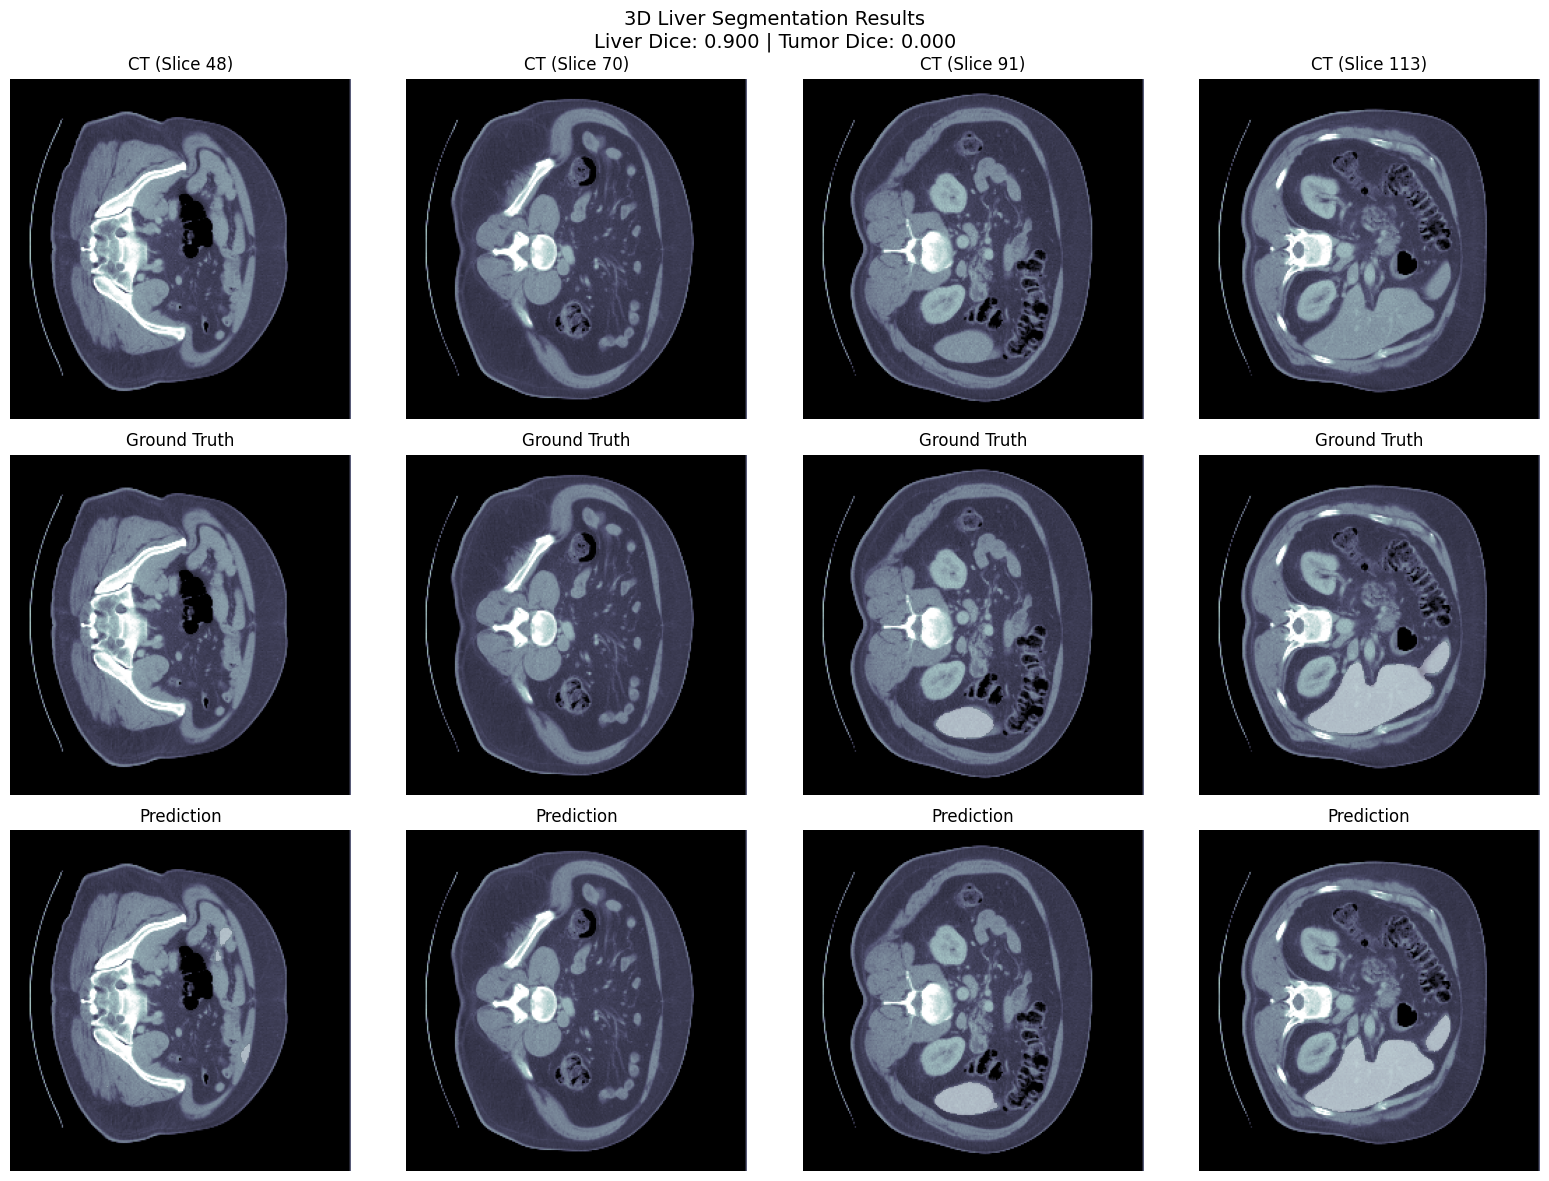

In [31]:
# Visualize predictions
ct_np = preprocessed['ct']['data'].numpy()[0]  # (D, H, W)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Show slices at different depths
slice_indices = np.linspace(ct_np.shape[2] * 0.3, ct_np.shape[2] * 0.7, 4).astype(int)

for col, slice_idx in enumerate(slice_indices):
    # CT
    axes[0, col].imshow(ct_np[:, :, slice_idx], cmap='bone')
    axes[0, col].set_title(f'CT (Slice {slice_idx})')
    axes[0, col].axis('off')

    # Ground truth
    axes[1, col].imshow(ct_np[:, :, slice_idx], cmap='bone')
    liver_gt = np.ma.masked_where(mask_volume[:, :, slice_idx] != 1, np.ones_like(mask_volume[:, :, slice_idx]))
    tumor_gt = np.ma.masked_where(mask_volume[:, :, slice_idx] != 2, np.ones_like(mask_volume[:, :, slice_idx]))
    axes[1, col].imshow(liver_gt, alpha=0.4, cmap='Blues')
    axes[1, col].imshow(tumor_gt, alpha=0.7, cmap='Reds')
    axes[1, col].set_title('Ground Truth')
    axes[1, col].axis('off')

    # Prediction
    axes[2, col].imshow(ct_np[:, :, slice_idx], cmap='bone')
    liver_pred = np.ma.masked_where(pred_volume[:, :, slice_idx] != 1, np.ones_like(pred_volume[:, :, slice_idx]))
    tumor_pred = np.ma.masked_where(pred_volume[:, :, slice_idx] != 2, np.ones_like(pred_volume[:, :, slice_idx]))
    axes[2, col].imshow(liver_pred, alpha=0.4, cmap='Blues')
    axes[2, col].imshow(tumor_pred, alpha=0.7, cmap='Reds')
    axes[2, col].set_title('Prediction')
    axes[2, col].axis('off')

axes[0, 0].set_ylabel('CT', fontsize=12)
axes[1, 0].set_ylabel('Ground Truth', fontsize=12)
axes[2, 0].set_ylabel('Prediction', fontsize=12)

plt.suptitle(f'3D Liver Segmentation Results\nLiver Dice: {dice_scores["Liver"]:.3f} | Tumor Dice: {dice_scores["Tumor"]:.3f}', fontsize=14)
plt.tight_layout()
plt.show()

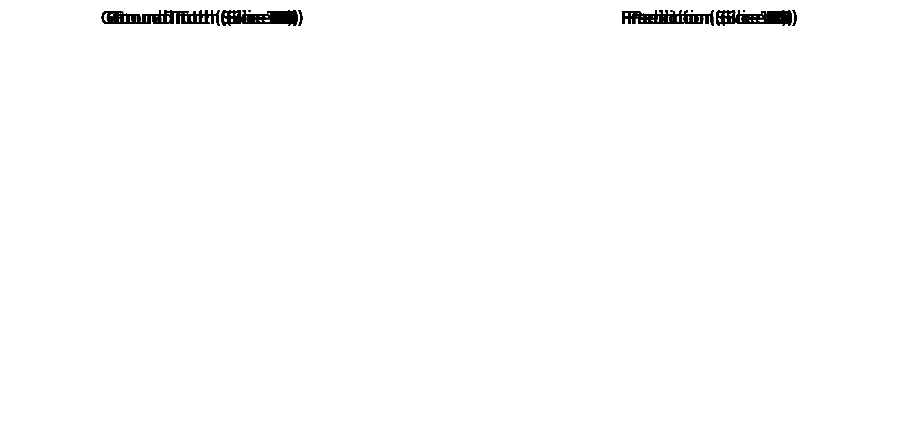

In [32]:
# 3D Volume Animation
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure(figsize=(12, 5))
camera = Camera(fig)

for i in range(0, ct_np.shape[2], 2):
    # Ground truth
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(ct_np[:, :, i], cmap='bone')
    liver_gt = np.ma.masked_where(mask_volume[:, :, i] != 1, np.ones_like(mask_volume[:, :, i]))
    tumor_gt = np.ma.masked_where(mask_volume[:, :, i] != 2, np.ones_like(mask_volume[:, :, i]))
    ax1.imshow(liver_gt, alpha=0.4, cmap='Blues')
    ax1.imshow(tumor_gt, alpha=0.7, cmap='Reds')
    ax1.set_title(f'Ground Truth (Slice {i})')
    ax1.axis('off')

    # Prediction
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(ct_np[:, :, i], cmap='bone')
    liver_pred = np.ma.masked_where(pred_volume[:, :, i] != 1, np.ones_like(pred_volume[:, :, i]))
    tumor_pred = np.ma.masked_where(pred_volume[:, :, i] != 2, np.ones_like(pred_volume[:, :, i]))
    ax2.imshow(liver_pred, alpha=0.4, cmap='Blues')
    ax2.imshow(tumor_pred, alpha=0.7, cmap='Reds')
    ax2.set_title(f'Prediction (Slice {i})')
    ax2.axis('off')

    camera.snap()

animation = camera.animate(interval=100)
HTML(animation.to_html5_video())

---
<a id='lessons'></a>
# Part 6: Lessons Learned

## Journey Through Medical Imaging

This course took us from raw medical images to production-ready segmentation models. Here's what we learned:

### 1. Data Matters More Than Models

| Lesson | Example |
|--------|--------|
| **Preprocessing is critical** | CT windowing, MRI normalization |
| **Augmentation prevents overfitting** | Especially with small medical datasets |
| **Class imbalance is the norm** | WeightedRandomSampler, Dice loss |

### 2. Domain Knowledge > Generic ML

Understanding the clinical context changes everything:
- **Hounsfield units** — CT has physical meaning, MRI doesn't
- **Anatomical priors** — Tumors are inside organs, not floating
- **Clinical metrics** — Dice matters more than accuracy for segmentation

### 3. Architecture Evolution

| Task | Architecture | Why |
|------|-------------|-----|
| Classification | ResNet18 | Transfer learning, proven |
| 2D Segmentation | U-Net | Skip connections for fine details |
| 3D Segmentation | 3D U-Net | Volumetric context |

### 4. Loss Function Selection

| Scenario | Loss | Rationale |
|----------|------|-----------|
| Balanced classes | Cross-Entropy | Simple, stable |
| Binary segmentation | Dice | Handles imbalance |
| Tiny objects | BCE | Stable gradients |
| Multi-class | CE + Dice | Best of both worlds |

### 5. Practical Considerations

- **Memory management** — 3D data is huge, use patches
- **Mixed precision** — float16 cuts memory in half
- **TorchIO** — Purpose-built for 3D medical imaging
- **Interpretability** — CAM, visualization builds clinical trust

---

## Portfolio Summary

| Notebook | Modality | Task | Key Innovation |
|----------|----------|------|----------------|
| Preprocessing | NIfTI/DICOM | Data prep | Affine matrices, CT/MRI normalization |
| Pneumonia | X-ray | Classification | Transfer learning, CAM |
| Atrium | Cardiac MRI | 2D Segmentation | U-Net, Dice loss |
| Lung Tumor | Chest CT | 2D Segmentation | Class imbalance handling |
| **Liver** | Abdominal CT | **3D Segmentation** | **Multi-class, TorchIO, 3D U-Net** |

---

## What's Next?

This foundation prepares you for:

1. **Advanced architectures** — nnU-Net, Swin UNETR, transformers
2. **Self-supervised learning** — Pre-training on unlabeled medical data
3. **Uncertainty quantification** — Know when the model is unsure
4. **Deployment** — ONNX, TensorRT, clinical integration
5. **Regulatory** — FDA pathways, clinical validation

---

**Congratulations!** You've completed the medical imaging journey. From DICOM pixels to 3D tumor segmentation — you now have the foundation to tackle real clinical problems. 🎉

---

*"The goal is not to build a model. The goal is to help a patient."*